# Library import

export wo code:
https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
data naming: 

naming:

df: with subj and dx. 

dat: only biomarker values. 

eoad_idx, cn_idx: row index to select subjects

zdf, zdata: cn standardized z-scores. zdata_eoad, zdata_ctrl: subset.

gmmdf, gmm_data: gmm 1st component standardized z-scores. gmm_eoad, gmm_ctrl: subset.



In [20]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys 
from matplotlib.lines import Line2D
sys.path.append('../') 

#  Input

In [3]:
cpath='/Users/mlin2/Desktop/RabLab/eoad_sustain_ml/data/'
ftp = pd.read_csv(cpath+'baseline_FTP_6mm.csv')
# visit = 1, parc = hemfs_roi - dropped
ftp.drop(['ftp_date'],axis=1,inplace=True)

In [4]:
ftp.rename(columns={'ftp_vol':'vol','ftp_suvr':'suvr'},inplace=True)
ftp.head(2)

,subj,dx,roi,suvr,vol
0,LDS0070120,CN,L_amygdala,1.106815,1818
1,LDS0070166,EOAD,L_amygdala,2.000921,1159


## Patient count

In [5]:
for i in ftp.dx.unique():
    print(i + ': '+str(len(ftp[ftp.dx==i].subj.unique())))

CN: 88
EOAD: 374
EOnonAD: 119


## ROI specification
(ref Vogel et al's)
For the ten spatial features, we opted for left and right lobar ROIs: **parietal; frontal; occipital; temporal; and MTL**. This choice is justified as follows: (1) previous imaging and pathology subtyping studies have revealed variation in AD pathology to often occur within specific lobes, for example, limbic-predominant (MTL), MTL-sparing (parietal), PCA (occipital), logopenic aphasia (temporal) and behavioral variant AD (perhaps frontal); (2) hemispheric laterality in AD is understudied perhaps due to pathological staining often occurring on single hemispheres. However, some laterality has been observed in AD clinical variants (that is, logopenic PPA15) and may point to differing phenotypes in typical AD; (3) these lobar regions maintain some orthogonality to disease progression since multiple lobes are involved in Braak stages IV–VI.

- Desikan map lobe-mapping: 
https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation?highlight=%28lobar%29 
- Desikan-Killiany-Touville:
https://www.freesurfer.net/pub/articles/desikan06-parcellation.pdf 
- Vogel sustain regional comparison:
https://www.nature.com/articles/s41591-021-01309-6/figures/8


**Lobe-mapping from D-K**
 
Medial temporal lobe:
entorhinal cortex, parahippocampal gyrus, fusiform gyrus (temporal pole)

Tempoeral lobe:
superior temporal gyrus, middle temporal gyrus, inferior temporal gyrus, transverse temporal gyrus, (bank)

Frontal lobe:
superior frontal gyrus, middle frontal gyrus, inferior frontal gyrus (pars opercularis, pars triangularis, pars orbitalis), orbitofrontal, precentral gyrus, paracentral lobule (frontal pole)

Parietal lobe:
postcentral gyrus, supramarginal gyrus, superior parietal, inferior parietal, percuneus

Occipital lobe:
lingual gyrus, pericalcarine cortex, cuneus cortex, lateral occipital cortex

Cingulate:
rostral anterior (f), caudal anterior (f), posterior (p), isthmus (p)


In [6]:
print(ftp.roi.unique())
print(len(ftp.roi.unique()))

['L_amygdala' 'L_bankssts' 'L_caudalanteriorcingulate'
 'L_caudalmiddlefrontal' 'L_cuneus' 'L_entorhinal' 'L_frontalpole'
 'L_fusiform' 'L_hippocampus' 'L_inferiorparietal' 'L_inferiortemporal'
 'L_insula' 'L_isthmuscingulate' 'L_lateraloccipital'
 'L_lateralorbitofrontal' 'L_lingual' 'L_medialorbitofrontal'
 'L_middletemporal' 'L_paracentral' 'L_parahippocampal'
 'L_parsopercularis' 'L_parsorbitalis' 'L_parstriangularis'
 'L_pericalcarine' 'L_postcentral' 'L_posteriorcingulate' 'L_precentral'
 'L_precuneus' 'L_rostralanteriorcingulate' 'L_rostralmiddlefrontal'
 'L_superiorfrontal' 'L_superiorparietal' 'L_superiortemporal'
 'L_supramarginal' 'L_temporalpole' 'L_transversetemporal' 'R_amygdala'
 'R_bankssts' 'R_caudalanteriorcingulate' 'R_caudalmiddlefrontal'
 'R_cuneus' 'R_entorhinal' 'R_frontalpole' 'R_fusiform' 'R_hippocampus'
 'R_inferiorparietal' 'R_inferiortemporal' 'R_insula' 'R_isthmuscingulate'
 'R_lateraloccipital' 'R_lateralorbitofrontal' 'R_lingual'
 'R_medialorbitofrontal' 

In [7]:
# create dict to map parcellations to lobar ROI
lobe_dict = {
'L_MTL': ['L_entorhinal','L_amygdala','L_hippocampus' ],
'R_MTL': ['R_entorhinal','R_amygdala','R_hippocampus'],

'L_temporal': ['L_superiortemporal', 'L_middletemporal', 'L_inferiortemporal','L_transversetemporal',
               'L_parahippocampal','L_fusiform'],
'R_temporal': ['R_superiortemporal', 'R_middletemporal','R_inferiortemporal','R_transversetemporal',
               'R_parahippocampal','R_fusiform'],

'L_frontal':['L_superiorfrontal','L_rostralmiddlefrontal','L_caudalmiddlefrontal', #middle frontal gyrus
             'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis', #inferior frontal gyrus 
            'L_lateralorbitofrontal','L_medialorbitofrontal', #occipitalfrontal cortex
            'L_rostralanteriorcingulate', 'L_caudalanteriorcingulate',#cingulate
            'L_precentral','L_insula'],
            
'R_frontal':['R_superiorfrontal', 'R_rostralmiddlefrontal', 'R_caudalmiddlefrontal',
             'R_parsopercularis', 'R_parsorbitalis', 'R_parstriangularis',  
             'R_lateralorbitofrontal','R_medialorbitofrontal',
             'R_rostralanteriorcingulate','R_caudalanteriorcingulate', 
              'R_precentral', 'R_insula'], #paracentral?
 
'L_occipital':['L_lateraloccipital','L_lingual','L_cuneus','L_pericalcarine'],
'R_occipital':['R_lateraloccipital','R_lingual','R_cuneus','R_pericalcarine'],

'L_parietal':['L_superiorparietal','L_inferiorparietal','L_supramarginal',
             'L_postcentral','L_precuneus',
             'L_posteriorcingulate','L_isthmuscingulate'],#cingulate
'R_parietal':['R_superiorparietal','R_inferiorparietal','R_supramarginal',
              'R_postcentral','R_precuneus', 
             'R_posteriorcingulate', 'R_isthmuscingulate']
}
# use this to subset data for correct ordering!
lobes = ['L_MTL', 'R_MTL', 'L_temporal', 'R_temporal', 'L_frontal', 'R_frontal', 
         'L_occipital', 'R_occipital','L_parietal', 'R_parietal' ]
ftp['lobe'] = ftp['roi'].apply(lambda roi: next((lobe for lobe, regions in lobe_dict.items() if roi in regions), None))
ftp.sort_values('subj').head(2)

,subj,dx,roi,suvr,vol,lobe
0,LDS0070120,CN,L_amygdala,1.106815,1818,L_MTL
11039,LDS0070120,CN,L_parahippocampal,1.126929,2237,L_temporal


In [8]:
#unassigned parcellated region: 
#banks of the superior temporal sculus (temporal), frontal pole (frontal), paracentral (frontal/parietal?), temporal pole (temporal)
print(len(ftp.roi.unique()))
ftp[ftp.lobe.isnull()].roi.unique()

72


array(['L_bankssts', 'L_frontalpole', 'L_paracentral', 'L_temporalpole',
       'R_bankssts', 'R_frontalpole', 'R_paracentral', 'R_temporalpole'],
      dtype=object)

In [9]:
#excluding L_hippocampus
lhm = ['L_entorhinal','L_amygdala','L_hippocampus']+ ['L_superiortemporal', 'L_middletemporal', 'L_inferiortemporal','L_transversetemporal',
               'L_parahippocampal','L_fusiform']+['L_superiorfrontal','L_rostralmiddlefrontal','L_caudalmiddlefrontal', #middle frontal gyrus
             'L_parsopercularis', 'L_parsorbitalis', 'L_parstriangularis', #inferior frontal gyrus 
            'L_lateralorbitofrontal','L_medialorbitofrontal', #occipitalfrontal cortex
            'L_rostralanteriorcingulate', 'L_caudalanteriorcingulate',#cingulate
            'L_precentral','L_insula']+['L_lateraloccipital','L_lingual','L_cuneus','L_pericalcarine']+['L_superiorparietal','L_inferiorparietal','L_supramarginal',
             'L_postcentral','L_precuneus',
             'L_posteriorcingulate','L_isthmuscingulate']
#excluding R_hippocampus
rhm = ['R_entorhinal','R_amygdala','R_hippocampus']+['R_superiortemporal', 'R_middletemporal','R_inferiortemporal','R_transversetemporal',
               'R_parahippocampal','R_fusiform']+['R_superiorfrontal', 'R_rostralmiddlefrontal', 'R_caudalmiddlefrontal',
             'R_parsopercularis', 'R_parsorbitalis', 'R_parstriangularis',  
             'R_lateralorbitofrontal','R_medialorbitofrontal',
             'R_rostralanteriorcingulate','R_caudalanteriorcingulate', 
              'R_precentral', 'R_insula']+['R_lateraloccipital','R_lingual','R_cuneus','R_pericalcarine']+['R_superiorparietal','R_inferiorparietal','R_supramarginal',
              'R_postcentral','R_precuneus', 
             'R_posteriorcingulate', 'R_isthmuscingulate']
len(rhm) == len(lhm)

True

In [19]:
lobedf = pd.DataFrame([(v, k) for k, vals in lobe_dict.items() for v in vals], columns=['parc', 'ROI'])
lobedf['parc'] = lobedf['parc'].str.split('_').str[-1]
lobedf['ROI'] = lobedf['ROI'].str.split('_').str[-1]
lobedf = lobedf.drop_duplicates()
lobedf.to_csv('lobarRoi_def.csv', index=False)

In [10]:
lrsuvr = ftp[ftp['roi'].isin(lhm+rhm)]
#lrsuvr.to_csv(cpath+'lrsuvr_mtl.csv',index=False)

## MTL exploration

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_25477/1240022307.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset.dropna()
/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_25477/1240022307.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  subset.dropna()
/Users/linlin/Library/Python/3.9/lib/python/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization

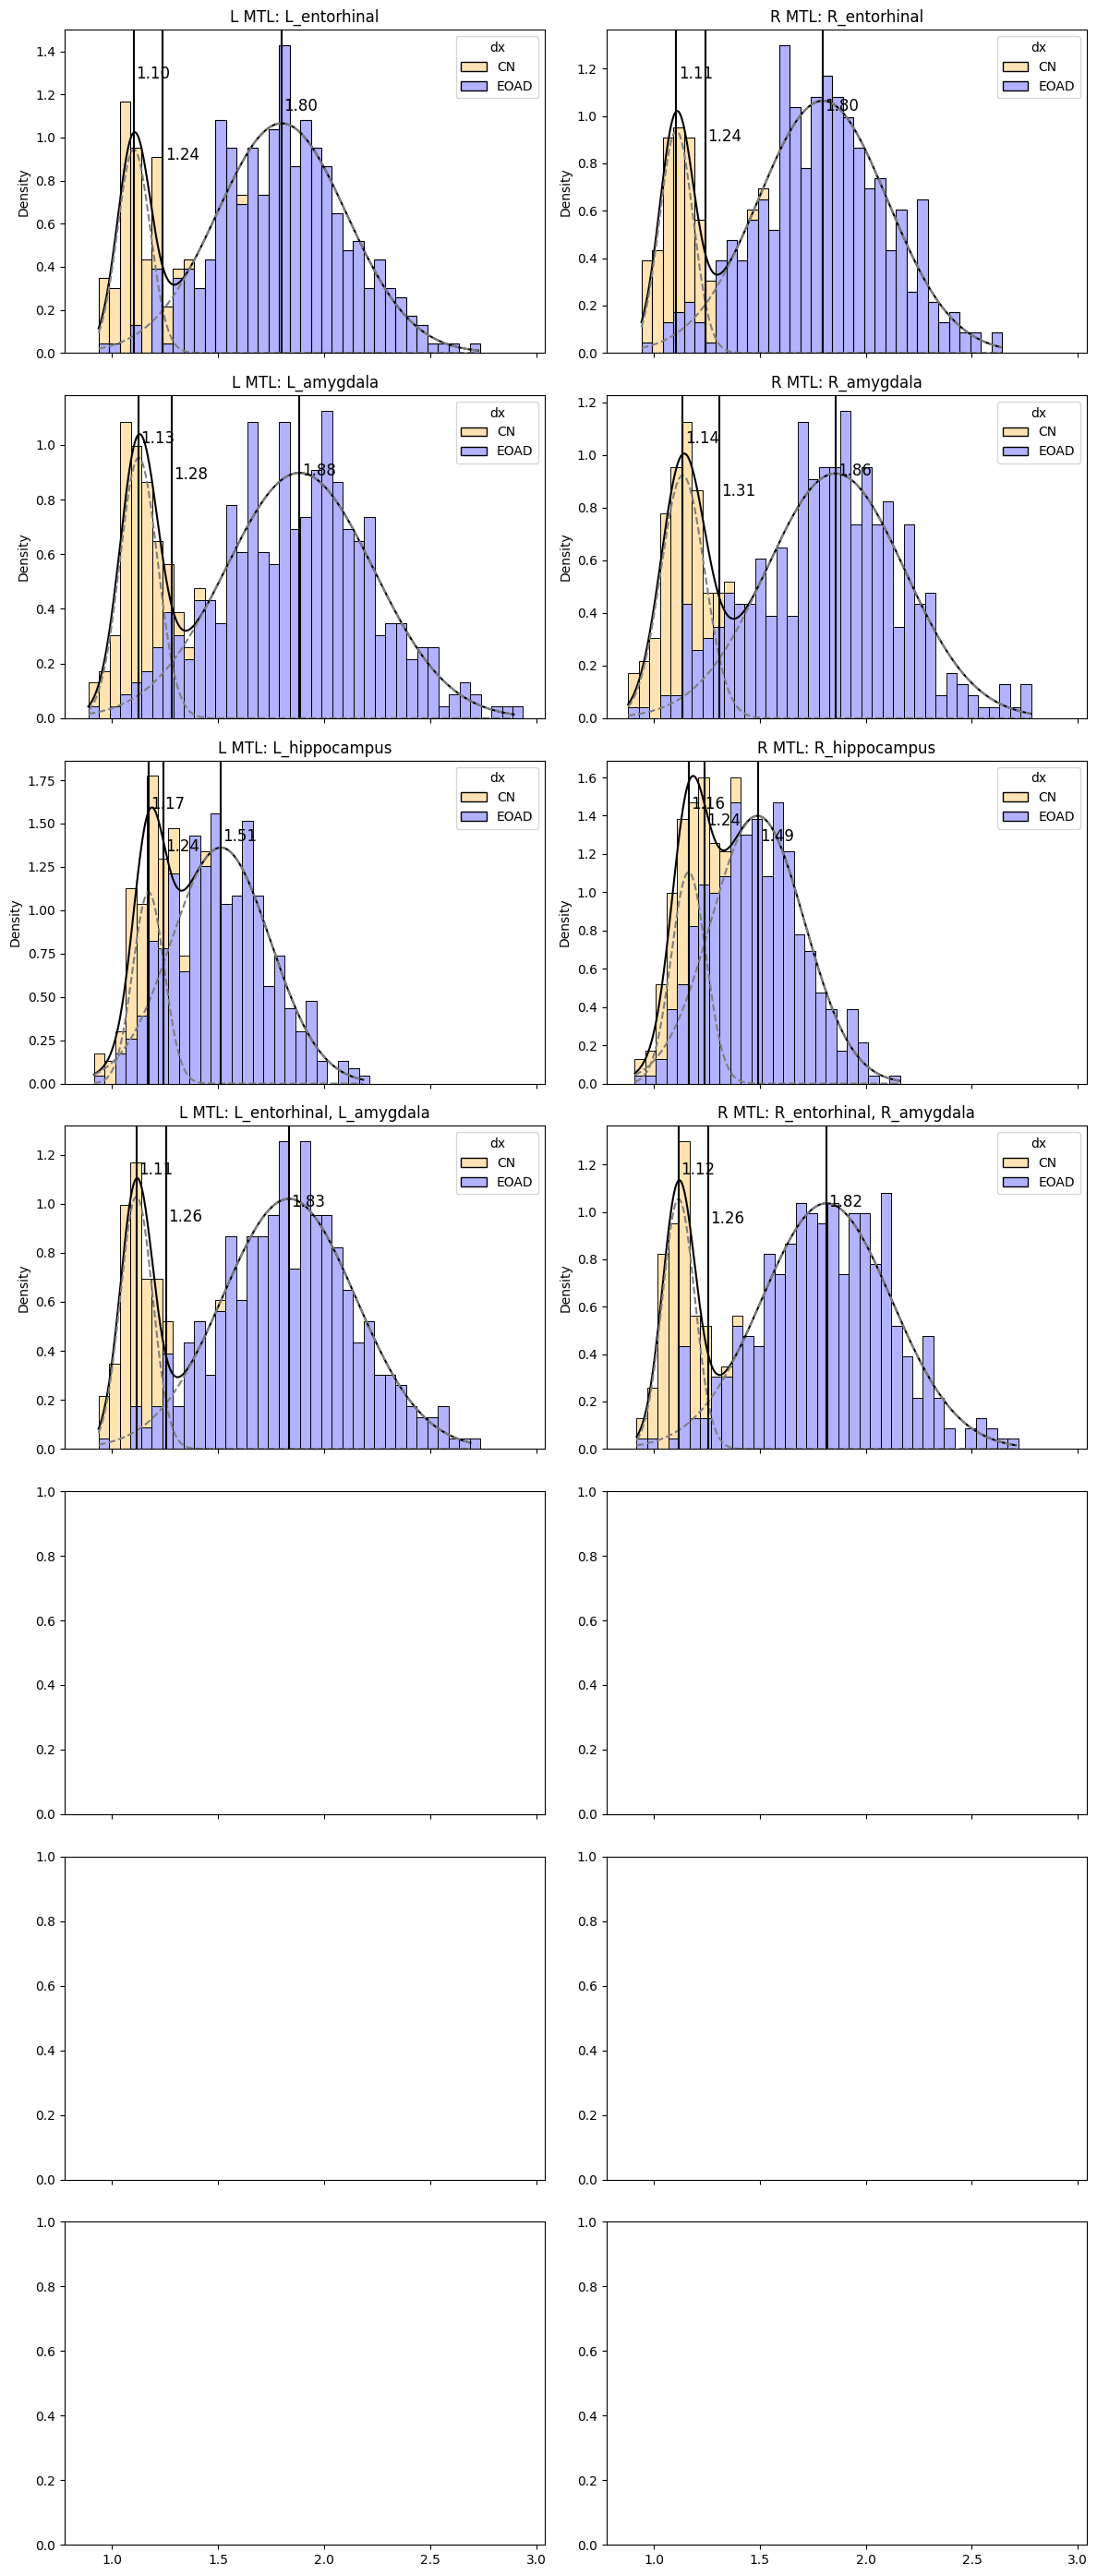

In [28]:
import itertools
from sklearn.mixture import GaussianMixture 

# Function to calculate the volume-weighted SUVR for given subregions
def calculate_weighted_suvr(df, subregions, lobe_name):
    subset = df[df['roi'].isin(subregions)].copy()
    mean_suvr_df = (
        subset.dropna()
        .groupby(['subj', 'dx'], as_index=False)
        .apply(lambda x: pd.Series({'weighted_suvr': np.average(x['suvr'], weights=x['vol'])}))
    )
    mean_suvr_df['lobe'] = lobe_name
    return mean_suvr_df

# Function to annotate ROI distribution with GMM components
def annotated_roi_dist(df, gmm, roi, stat='density', separate=True, annotate=True, ax=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots()

    # ROI data and diagnosis
    roi_data = df['weighted_suvr']
    dx = df['dx']
    roi_df = pd.DataFrame({'roi': roi_data, 'dx': dx}).dropna()  # Drop NaN values

    # GMM fit
    gmm.fit(roi_data.values.reshape(-1, 1))
    sorted_idx = np.argsort(gmm.means_.flatten())
    means = np.sort(gmm.means_.flatten())
    stds = np.sqrt(gmm.covariances_.flatten())[sorted_idx]

    # Generate PDFs
    x = np.linspace(roi_data.min(), roi_data.max(), 1000)
    pdf = np.exp(gmm.score_samples(x.reshape(-1, 1)))
    ax.plot(x, pdf, color='black', linestyle='-', label='Overall PDF')

    # Plot component PDFs
    weights = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = weights * pdf[:, np.newaxis]
    for i in range(pdf_individual.shape[1]):
        ax.plot(x, pdf_individual[:, i], '--', color='gray', label=f'Component {i + 1}')

    # Intersection line
    intersection_idx = (x > means[0]) & (x < means[1])
    diff = np.abs(pdf_individual[:, 0][intersection_idx] - pdf_individual[:, 1][intersection_idx])
    intersection = x[intersection_idx][np.argmin(diff)]
    ax.axvline(intersection, color='black', linestyle='-', label='Intersection')
    ax.text(intersection + 0.01, ax.get_ylim()[1] * 0.8, f'{intersection:.2f}', color='black', fontsize=12)

    # Histogram with custom colors for CN and EOAD
    colors = {'CN': 'orange', 'EOAD': 'blue'}
    sns.histplot(
        roi_df, x='roi', hue='dx', stat=stat, multiple='stack', binwidth=0.05, palette=colors, alpha=0.3, ax=ax
    )

    for i, mean in enumerate(means):
        ax.axvline(mean, color='black', linestyle='-', label=f'Mean {i + 1}')
        ax.text(mean + 0.01, ax.get_ylim()[1] * (0.85 - 0.1 * i), f'{mean:.2f}', fontsize=12)

    ax.set_title(f'{roi}')
    ax.set_xlabel('Weighted SUVR')
    ax.set_ylabel('Density')
    return ax


# Define subregions for left and right
L_MTL_subregions = ['L_entorhinal', 'L_amygdala', 'L_hippocampus']
R_MTL_subregions = ['R_entorhinal', 'R_amygdala', 'R_hippocampus']

# Generate all combinations of subregions
left_combinations = [list(combo) for n in range(1, len(L_MTL_subregions) + 1) for combo in itertools.combinations(L_MTL_subregions, n)]
right_combinations = [list(combo) for n in range(1, len(R_MTL_subregions) + 1) for combo in itertools.combinations(R_MTL_subregions, n)]

# Filter data to only CN and EOAD subjects
filtered_data = lrsuvr[lrsuvr['dx'].isin(['CN', 'EOAD'])].replace([np.inf, -np.inf], np.nan).dropna()  # Handle infinities and NaNs

# Plot GMM for all combinations with shared x-axis
gmm = GaussianMixture(n_components=2, random_state=42, init_params='random_from_data', tol=0, max_iter=300)
fig, axes = plt.subplots(len(left_combinations), 2, figsize=(12, len(left_combinations) * 4), sharex=True)

for i, (left_combo, right_combo) in enumerate(zip(left_combinations, right_combinations)):
    if i <4:
        l_mtl_suvr = calculate_weighted_suvr(filtered_data, left_combo, 'L_MTL')
        r_mtl_suvr = calculate_weighted_suvr(filtered_data, right_combo, 'R_MTL')

        annotated_roi_dist(l_mtl_suvr, gmm, 'L_MTL', ax=axes[i, 0])
        annotated_roi_dist(r_mtl_suvr, gmm, 'R_MTL', ax=axes[i, 1])

        axes[i, 0].set_title(f'L MTL: {", ".join(left_combo)}')
        axes[i, 1].set_title(f'R MTL: {", ".join(right_combo)}')

plt.tight_layout()
plt.show()


## Volume-weighted mean SUVR

In [ ]:
lftp = ftp.dropna().groupby(['subj', 'dx',  'lobe']).apply(lambda x: np.average(x['suvr'], weights=x['vol'])).reset_index(name='mean_suvr')
#lftp.to_csv(cpath+'lftp_mtl.csv',index=False)
lftp.head(2)

/var/folders/zm/03ps49bx5fsdfvh986zjlbr00000gn/T/ipykernel_65455/4167101958.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lftp = ftp.dropna().groupby(['subj', 'dx',  'lobe']).apply(lambda x: np.average(x['suvr'], weights=x['vol'])).reset_index(name='mean_suvr')


,subj,dx,lobe,mean_suvr
0,LDS0070120,CN,L_MTL,1.182346
1,LDS0070120,CN,L_frontal,1.042777


In [11]:
# verify row 0 value
ftp[(ftp['subj'] == 'LDS0070120') & (ftp['roi'].isin(['L_amygdala','L_entorhinal','L_hippocampus']))]

,subj,dx,roi,suvr,vol,lobe
0,LDS0070120,CN,L_amygdala,1.106815,1818,L_MTL
2905,LDS0070120,CN,L_entorhinal,1.251838,1976,L_MTL
4648,LDS0070120,CN,L_hippocampus,1.234625,4706,L_MTL


In [12]:
#check. old L_MTL value for LDS0070120
(1.106815*1818+1.251838*1976+1.234625*4706)/(1818+1976+4706)

1.2112902127058824

## Visualize L/R value difference 
 

In [59]:
# add columns to indicate L/R and ROI
lrftp = lftp.copy()
lrftp['L/R'] = lftp['lobe'].str[0].map({'L':'Left','R':'Right'})
lrftp['ROI'] = lftp['lobe'].str.split('_').str[1]
lrftp.head(2)

,subj,dx,lobe,mean_suvr,L/R,ROI
0,LDS0070120,CN,L_MTL,1.182346,Left,MTL
1,LDS0070120,CN,L_frontal,1.042777,Left,frontal


/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


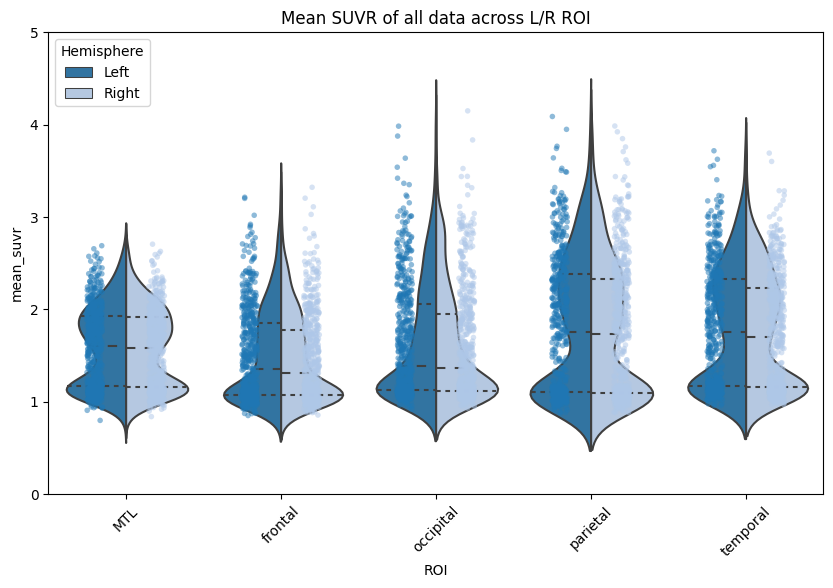

In [60]:
plt.figure(figsize=(10, 6))
sns.set_palette('tab20')
sns.violinplot(data=lrftp, x='ROI', fill=False, inner="quart", split=True, hue='L/R', y='mean_suvr')
sns.stripplot(data=lrftp, x='ROI', hue='L/R', y='mean_suvr', dodge=True,jitter=True, alpha=0.5, size = 4, legend = False)#marker='o'

plt.legend(loc='upper left', title='Hemisphere')
plt.title('Mean SUVR of all data across L/R ROI')
plt.ylim([0,5])
plt.xticks(rotation=45)
plt.show()


In [61]:
def roi_cluster_violin(data, x, y,roi_name,hue_cat,title_text,labels,strip=True,colors = sns.set_palette('tab20'),**kwargs): 
    #each x gets its own violin. hue splits the violin. each roi get its own plot. 
    #inner: “box”, “quart”, “point”, “stick”,
    # Define the pairs  
    pairs = [
        ('L_MTL', 'R_MTL'),
        ('L_temporal', 'R_temporal'),
        ('L_frontal', 'R_frontal'),
        ('L_occipital', 'R_occipital'),
        ('L_parietal', 'R_parietal')
    ]
    fig, axes = plt.subplots(1,5,figsize=(26,6), sharey = True)#, dpi=480)

    for i, (lobe_l, lobe_r) in enumerate(pairs):
        #row = i // 5
        col = i % 5
        sns.violinplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], x=x, y=y, hue=hue_cat, 
                    split=True,
                    fill=False,
                    ax=axes[col],palette=colors,**kwargs)
        if strip:
            sns.stripplot(data=data[data[roi_name].isin([lobe_l, lobe_r])], 
                      x=x, y=y, hue=hue_cat, 
                    dodge=True,jitter=True, alpha=0.5, size = 4, legend = False,ax=axes[col],palette=colors)#marker='o'

        axes[col].set_title(lobe_l[2:],fontsize=16)
        axes[col].set_xlabel(None) 
        axes[col].set_ylabel(None)#lobe_l[2:],fontsize=16)
        axes[col].tick_params(axis='y', labelsize=16)    
        axes[col].tick_params(axis='x', labelsize=16)   

        # Set legend to None for all subplots except the last one
        if i != len(pairs):
            handles, _ = axes[ col].get_legend_handles_labels()
            axes[col].legend().set_visible(False)  

    # Create a single legend in the last subplot
    axes[0].legend(handles, labels, loc='upper left')
    plt.yticks(size=15)
    plt.suptitle(title_text,fontsize=16)
    plt.tight_layout()
    plt.show()


/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/linlin/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

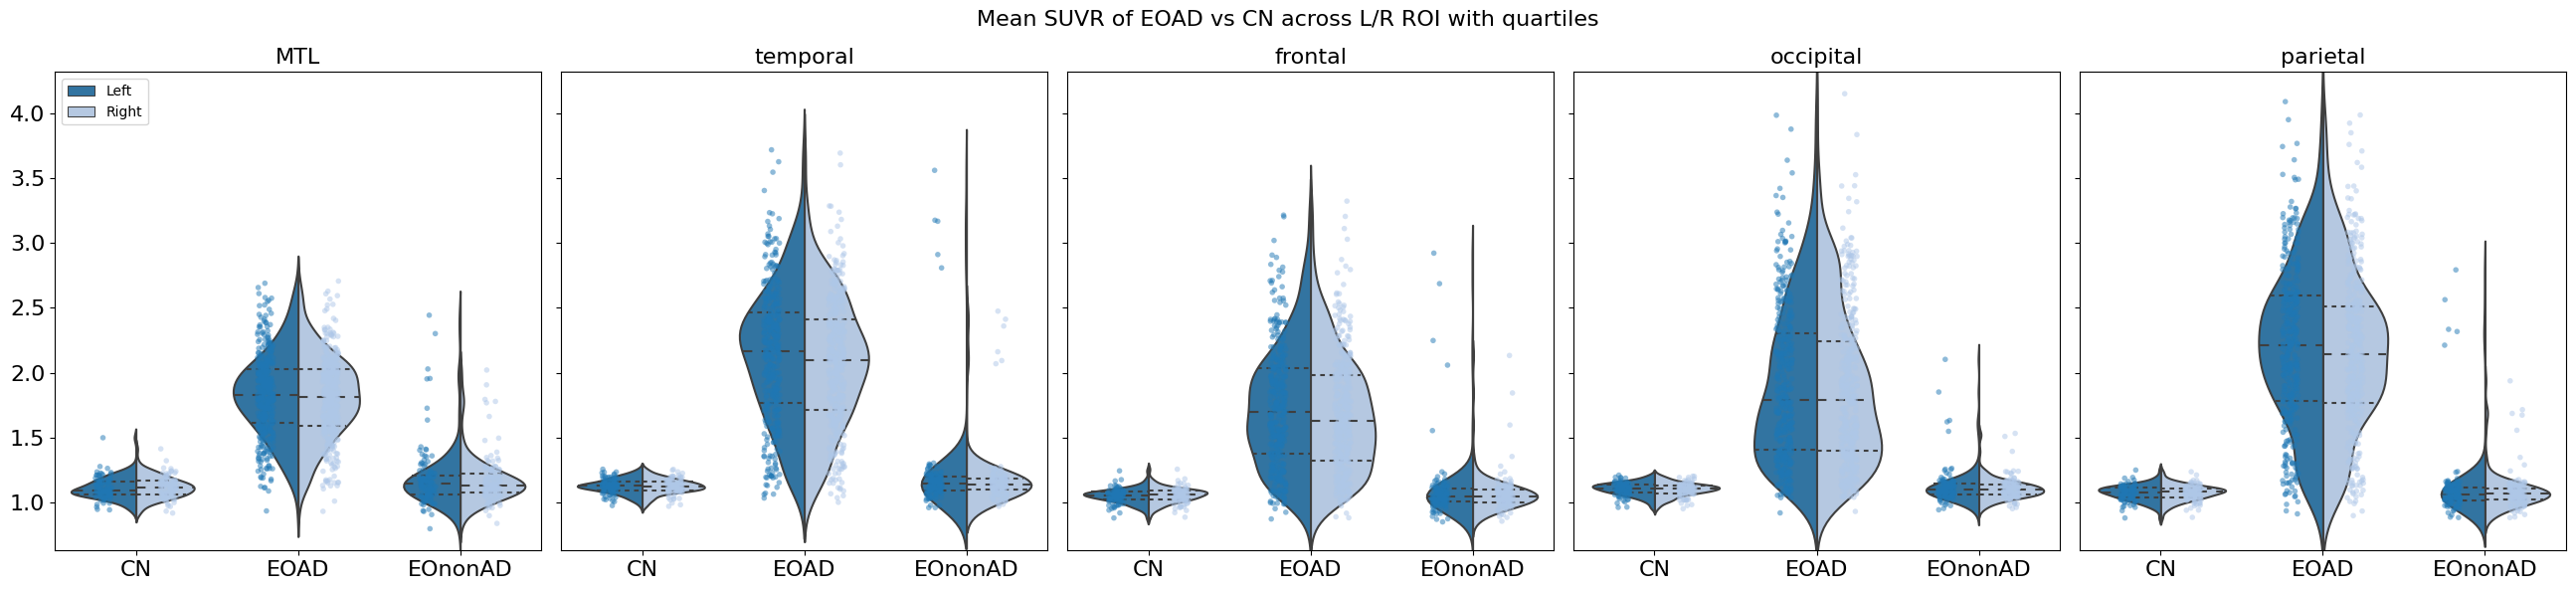

In [62]:
roi_cluster_violin(lftp,
                   x = 'dx',
                   y = 'mean_suvr',
                   roi_name = 'lobe',
                   hue_cat = 'lobe',
                   title_text = 'Mean SUVR of EOAD vs CN across L/R ROI with quartiles',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   #additional
                   inner='quart')

# bgmm section

In [22]:
bgmm = pd.read_csv(cpath+'bgmmdata.csv')
bgmm.head(2)

,L_MTL,R_MTL,L_temporal,R_temporal,L_frontal,R_frontal,L_occipital,R_occipital,L_parietal,R_parietal,dx,subj
0,0.762184,0.712056,-0.099457,0.182485,-0.547740,-0.819286,-0.185516,-0.024025,-0.246533,0.049455,CN,LDS0070120
1,9.063335,6.728621,32.301823,28.063757,25.098143,19.565545,37.458792,33.348817,32.426554,30.387741,EOAD,LDS0070166


In [31]:
df_long = pd.melt(bgmm, id_vars=['subj', 'dx'], var_name='lobe', value_name='mean_suvr')

# Extract the 'L/R' and 'ROI' columns from the 'lobe' column
df_long['L/R'] = df_long['lobe'].apply(lambda x: 'Left' if x.startswith('L_') else 'Right')
df_long['ROI'] = df_long['lobe'].apply(lambda x: x.split('_')[1])

# Reorder columns
df_long = df_long[['subj', 'dx', 'lobe', 'mean_suvr', 'L/R', 'ROI']]
df_long.rename(columns={'mean_suvr':'BGMM-z'},inplace=True)
df_long

,subj,dx,lobe,BGMM-z,L/R,ROI
0,LDS0070120,CN,L_MTL,0.762184,Left,MTL
1,LDS0070166,EOAD,L_MTL,9.063335,Left,MTL
2,LDS0070174,EOAD,L_MTL,2.268737,Left,MTL
3,LDS0070176,CN,L_MTL,-0.936595,Left,MTL
4,LDS0070199,EOAD,L_MTL,4.389933,Left,MTL
...,...,...,...,...,...,...
4665,LDS9410572,EOAD,R_parietal,16.281412,Right,parietal
4666,LDS9410574,EOAD,R_parietal,21.758481,Right,parietal
4667,LDS9410608,EOAD,R_parietal,11.351177,Right,parietal
4668,LDS9410622,EOAD,R_parietal,-2.501161,Right,parietal


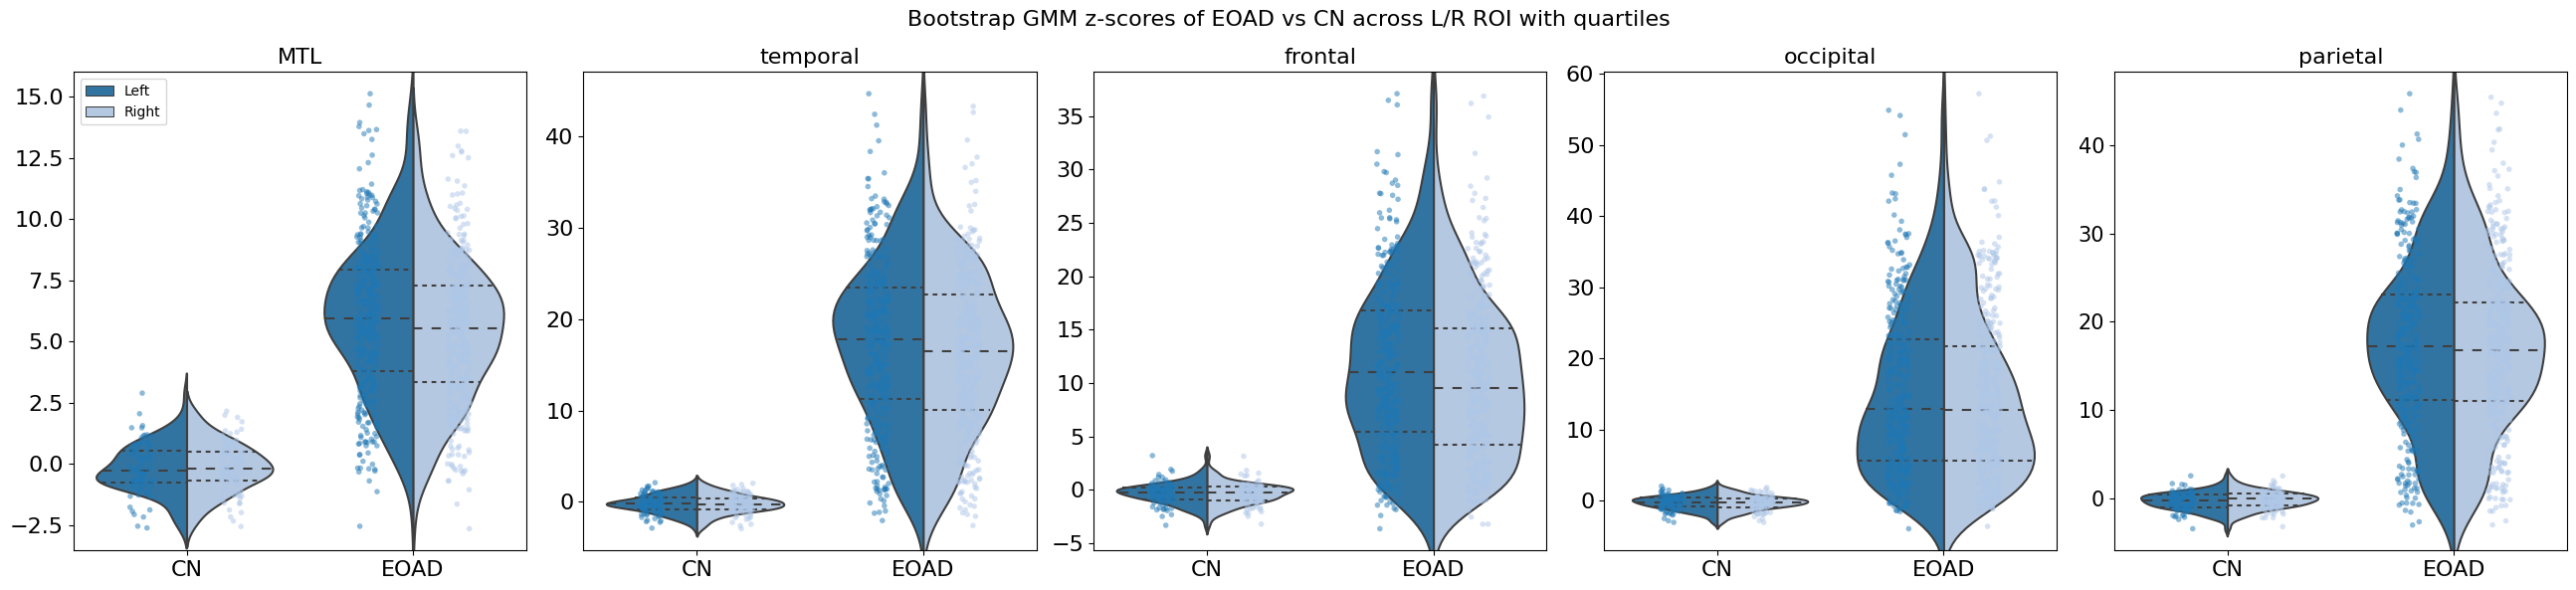

In [36]:
roi_cluster_violin(df_long,
                   x = 'dx',
                   y = 'BGMM-z',
                   roi_name = 'lobe',
                   hue_cat = 'lobe',
                   title_text = 'Bootstrap GMM z-scores of EOAD vs CN across L/R ROI with quartiles',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   #additional
                   inner='quart')

# cn z section

In [34]:
zdf = pd.read_csv(cpath+'zdata.csv')
zlftp = pd.melt(bgmm, id_vars=['subj', 'dx'], var_name='lobe', value_name='CN-z')

# Extract the 'L/R' and 'ROI' columns from the 'lobe' column
zlftp['L/R'] = zlftp['lobe'].apply(lambda x: 'Left' if x.startswith('L_') else 'Right')
zlftp['ROI'] = zlftp['lobe'].apply(lambda x: x.split('_')[1])

# Reorder columns
zlftp = zlftp[['subj', 'dx', 'lobe', 'CN-z', 'L/R', 'ROI']]
zlftp

FileNotFoundError: [Errno 2] No such file or directory: '/Users/linlin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/cap/dataexp/pySuStaIn/dat/zdata.csv'

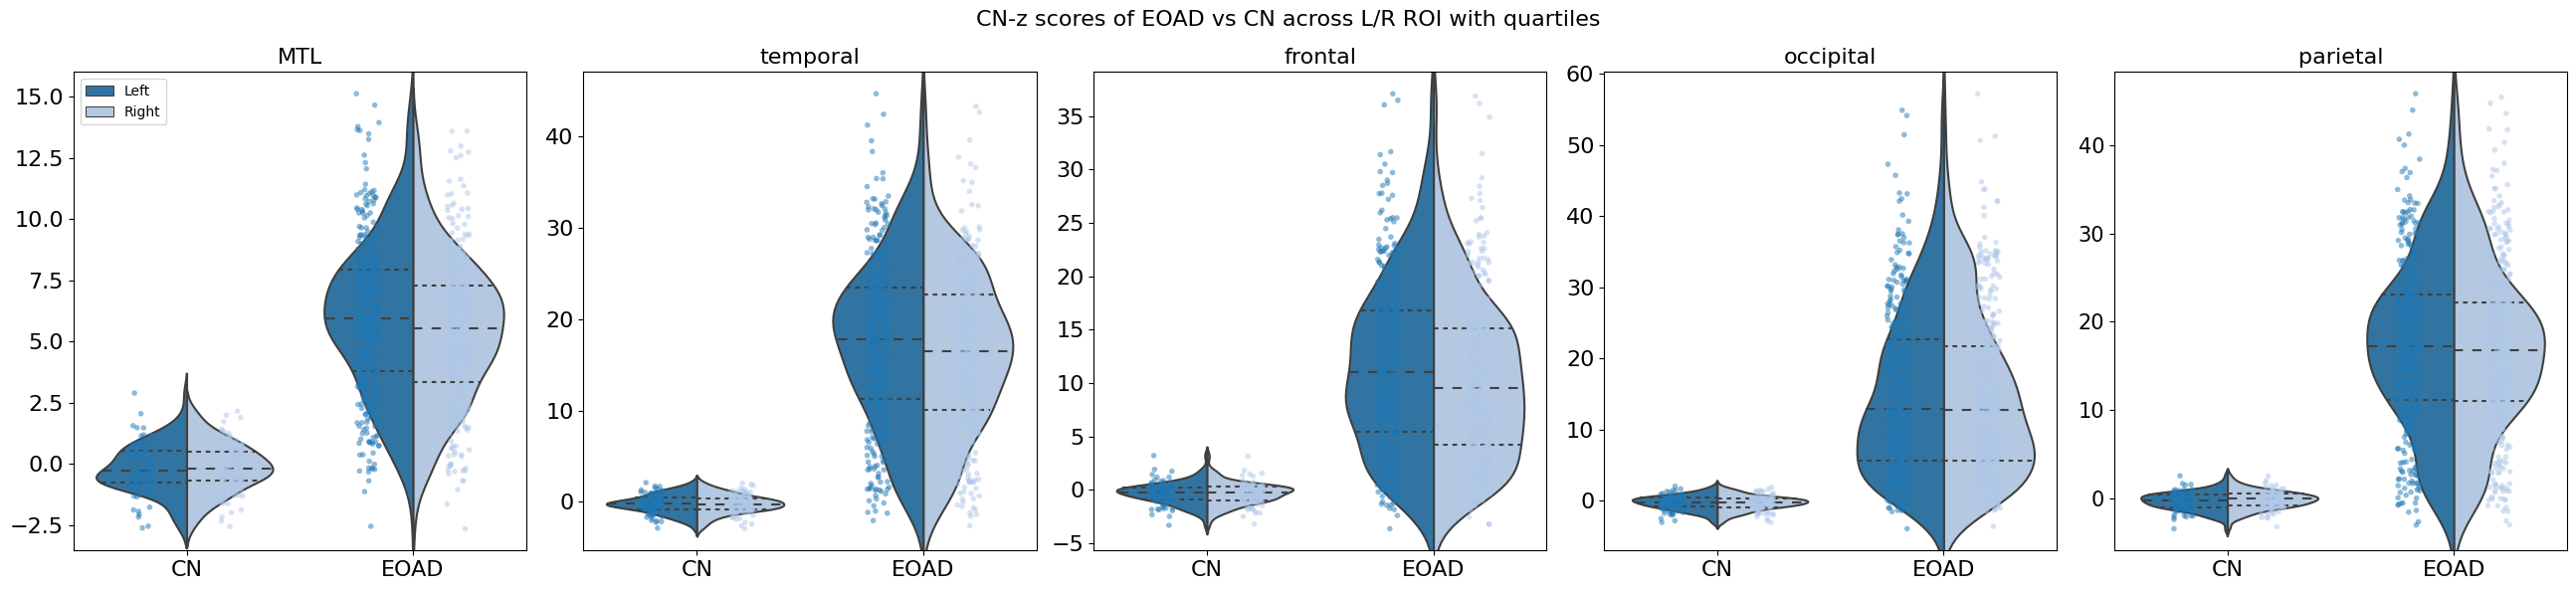

In [43]:
roi_cluster_violin(zlftp,
                   x = 'dx',
                   y = 'CN-z',
                   roi_name = 'lobe',
                   hue_cat = 'lobe',
                   title_text = 'CN-z scores of EOAD vs CN across L/R ROI with quartiles',
                   labels = ['Left','Right'],
                   strip = True,
                   colors = sns.set_palette('tab20'),
                   #additional
                   inner='quart')

# Long to wide for sustain

In [ ]:

df = lftp.pivot_table(index=['subj', 'dx'], columns='lobe', values='mean_suvr').reset_index()
#df.to_csv(cpath+'wide_data_mtl.csv',index=False) 
df.head(2)

lobe,subj,dx,L_MTL,L_frontal,L_occipital,L_parietal,L_temporal,R_MTL,R_frontal,R_occipital,R_parietal,R_temporal
0,LDS0070120,CN,1.182346,1.042777,1.108455,1.078236,1.133259,1.186170,1.03524,1.113742,1.085099,1.149995
1,LDS0070166,EOAD,2.076745,2.520749,3.096130,3.158491,3.005546,1.876031,2.25349,2.846904,3.013359,2.766408
